**Общая информация**

**Срок сдачи:** 20 марта 2019, 06:00 <br\>
**Штраф за опоздание:** -1 балл после 06:00 20 марта, -2 балла после 06:00 27 марта, -3 балла после 06:00 3 апреля
-4 балла после 06:00 10 апреля

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush

Необходимо в slack скинуть ссылку в личный чат @alkhamush
Пример ссылки:
https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##### Задание 1 (2 баллов)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

###### Задание 2 (2 балла)
Добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris и mnist
Для этого используем numpy

###### Задание 3 (2 балла)
Для iris найдите такой параметр n_neighbors, при котором выдаётся наилучший score. Нарисуйте график зависимости score от n_neighbors

###### Задание 4 (3 балла)
Добавить algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris и mnist
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

###### Задание 5 (1 балла)
Описать для чего нужны следующие библиотеки/классы/функции (список будет ниже)

**Штрафные баллы:**

1. Невыполнение PEP8 -0.5 баллов
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять структуру кода и текст. В противном случае -0.5 баллов


In [197]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata
from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KDTree
from scipy import stats
from mlxtend.data import loadlocal_mnist

%load_ext pycodestyle_magic

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [245]:
%%pycodestyle


class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin,
                             SupervisedIntegerMixin, ClassifierMixin):
    def __init__(self, n_neighbors, algorithm):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm

    def fit(self, X, y):
        self.classes = np.unique(y)
        if self.algorithm == 'brute':
            self.X = X
            self.y = y
        elif self.algorithm == 'kd_tree':
            self.tree = KDTree(X)
            self.y = y

    def kneighbors(self, X):
        if self.algorithm == 'brute':
            neighbors = pairwise_distances(X=X, Y=self.X)
            k_ind = neighbors.argpartition(self.n_neighbors)
            k_ind = k_ind[:, :self.n_neighbors]
            k_dist = neighbors[:, k_ind]
        elif self.algorithm == 'kd_tree':
            k_dist, k_ind = self.tree.query(X, k=self.n_neighbors)
        return k_dist, k_ind

    def predict(self, X):
        X = X.astype(float)
        k_dist, k_ind = self.kneighbors(X)
        n_samples = X.shape[0]
        y_pred = np.zeros(X.shape[0], dtype=int)
        for idx, k in enumerate(k_ind):
            mode, _ = stats.mode(self.y[np.array(k)])
            y_pred[idx] = mode[0]
        return y_pred

    def predict_proba(self, X):
        X = X.astype(float)
        neigh_dist, neigh_ind = self.kneighbors(X)

        classes_ = self.classes
        _y = self.y

        n_samples = X.shape[0]
        weights = np.ones_like(neigh_ind)

        all_rows = np.arange(X.shape[0])
        probabilities = []
        _y = self.y.reshape((-1, 1))
        classes_ = [self.classes]
        for k, classes_k in enumerate(classes_):
            pred_labels = _y[:, k][neigh_ind]
            proba_k = np.zeros((n_samples, classes_k.size))
            for i, idx in enumerate(pred_labels.T):
                proba_k[all_rows, idx] += weights[:, i]
            normalizer = proba_k.sum(axis=1)[:, np.newaxis]
            normalizer[normalizer == 0.0] = 1.0
            proba_k /= normalizer

            probabilities.append(proba_k)
        return probabilities

    def score(self, X, y):
        Y = self.predict(X)
        return np.mean(y == Y)


**IRIS**

In [246]:
iris = datasets.load_iris()

In [247]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [248]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [249]:
%time clf.fit(X_train, y_train)

CPU times: user 1.02 ms, sys: 885 µs, total: 1.91 ms
Wall time: 1.34 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [250]:
%time my_clf.fit(X_train, y_train)

CPU times: user 178 µs, sys: 111 µs, total: 289 µs
Wall time: 196 µs


In [251]:
%time clf.predict(X_test)

CPU times: user 1.82 ms, sys: 1.05 ms, total: 2.87 ms
Wall time: 2.09 ms


array([2, 2, 1, 1, 0, 0, 1, 2, 2, 0, 0, 2, 0, 1, 1])

In [252]:
%time my_clf.predict(X_test)

CPU times: user 3.79 ms, sys: 842 µs, total: 4.63 ms
Wall time: 3.95 ms


array([2, 2, 1, 1, 0, 0, 1, 2, 2, 0, 0, 2, 0, 1, 1])

In [253]:
%time clf.predict_proba(X_test)

CPU times: user 1.64 ms, sys: 988 µs, total: 2.63 ms
Wall time: 1.86 ms


array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [254]:
%time my_clf.predict_proba(X_test)

CPU times: user 1.29 ms, sys: 923 µs, total: 2.22 ms
Wall time: 1.39 ms


[array([[0., 0., 1.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.]])]

In [255]:
clf.score(X_test, y_test)

1.0

In [256]:
my_clf.score(X_test, y_test)

1.0

Задание 3

Best score by n_neighbors =  11


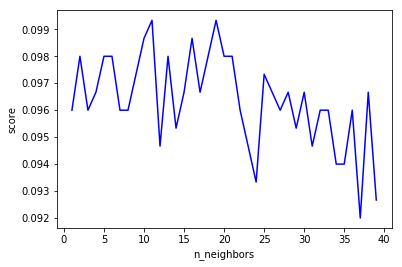

In [257]:
results = [0]
for neighbors in range(1, 40):
    sum = 0
    for it in range(10):
        X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)
        clf = MyKNeighborsClassifier(n_neighbors=neighbors, algorithm="brute")
        clf.fit(X_train, y_train)
        sum += clf.score(X_test, y_test)
    results.append(sum / 100)
    
best = np.argmax(results)
print("Best score by n_neighbors = ", best)
plt.plot(range(1, 40), results[1:], color='blue')
plt.xlabel('n_neighbors')
plt.ylabel('score')
plt.show()

**MNIST**

In [212]:
XMnist, yMnist = loadlocal_mnist(
        images_path='/Users/aleksandra/desktop/train-images-idx3-ubyte', 
        labels_path='/Users/aleksandra/desktop/train-labels-idx1-ubyte')

In [213]:
X_train, X_test, y_train, y_test = train_test_split(XMnist, yMnist, test_size=0.01, stratify=yMnist)

In [214]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [215]:
%time clf.fit(X_train, y_train)

CPU times: user 6.75 ms, sys: 1.46 ms, total: 8.21 ms
Wall time: 7.37 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [216]:
%time my_clf.fit(X_train, y_train)

CPU times: user 2.55 ms, sys: 733 µs, total: 3.29 ms
Wall time: 2.17 ms


In [217]:
%time clf.predict(X_test)

CPU times: user 3.28 s, sys: 875 ms, total: 4.16 s
Wall time: 3.37 s


array([0, 0, 8, 3, 3, 5, 1, 6, 1, 6, 9, 0, 4, 0, 6, 6, 7, 7, 2, 3, 5, 0,
       3, 9, 3, 0, 1, 7, 1, 6, 7, 5, 8, 3, 7, 9, 1, 4, 3, 2, 9, 9, 5, 0,
       0, 4, 7, 3, 9, 9, 0, 0, 1, 2, 1, 5, 7, 0, 5, 2, 8, 3, 9, 7, 9, 5,
       9, 4, 0, 9, 9, 4, 2, 8, 2, 4, 7, 2, 8, 1, 8, 8, 9, 2, 2, 9, 5, 2,
       3, 8, 6, 6, 1, 4, 3, 6, 1, 9, 1, 4, 2, 6, 7, 8, 6, 6, 1, 6, 6, 8,
       5, 8, 6, 3, 6, 4, 3, 2, 7, 9, 7, 9, 3, 3, 0, 8, 8, 1, 2, 8, 1, 4,
       2, 2, 7, 2, 6, 7, 3, 3, 4, 2, 7, 8, 7, 2, 1, 2, 7, 5, 0, 3, 4, 4,
       4, 6, 5, 2, 9, 6, 7, 3, 1, 0, 5, 1, 9, 4, 4, 5, 1, 6, 0, 9, 3, 5,
       0, 2, 0, 0, 0, 2, 4, 0, 0, 3, 1, 3, 5, 8, 1, 9, 6, 6, 1, 9, 0, 4,
       2, 1, 8, 1, 5, 6, 9, 1, 8, 4, 5, 2, 8, 3, 1, 4, 0, 9, 6, 6, 5, 9,
       1, 8, 4, 8, 7, 2, 8, 2, 3, 7, 2, 8, 1, 9, 0, 5, 8, 1, 9, 4, 3, 4,
       1, 1, 2, 7, 4, 8, 2, 3, 6, 9, 5, 5, 5, 0, 6, 1, 6, 7, 3, 1, 4, 4,
       6, 7, 1, 2, 5, 6, 5, 1, 3, 3, 7, 3, 3, 7, 9, 6, 8, 4, 6, 6, 3, 0,
       5, 7, 6, 9, 1, 3, 2, 2, 0, 0, 1, 7, 1, 5, 9,

In [218]:
%time my_clf.predict(X_test)

CPU times: user 2.9 s, sys: 450 ms, total: 3.35 s
Wall time: 2.26 s


array([0, 0, 8, 3, 3, 5, 1, 6, 1, 6, 9, 0, 4, 0, 6, 6, 7, 7, 2, 3, 5, 0,
       3, 9, 3, 0, 1, 7, 1, 6, 7, 5, 8, 3, 7, 9, 1, 4, 3, 2, 9, 9, 5, 0,
       0, 4, 7, 3, 9, 9, 0, 0, 1, 2, 1, 5, 7, 0, 5, 2, 8, 3, 9, 7, 9, 5,
       9, 4, 0, 9, 9, 4, 2, 8, 2, 4, 7, 2, 8, 1, 8, 8, 9, 2, 2, 9, 5, 2,
       3, 8, 6, 6, 1, 4, 3, 6, 1, 9, 1, 4, 2, 6, 7, 8, 6, 6, 1, 6, 6, 8,
       5, 8, 6, 3, 6, 4, 3, 2, 7, 9, 7, 9, 3, 3, 0, 8, 8, 1, 2, 8, 1, 4,
       2, 2, 7, 2, 6, 7, 3, 3, 4, 2, 7, 8, 7, 2, 1, 2, 7, 5, 0, 3, 4, 4,
       4, 6, 5, 2, 9, 6, 7, 3, 1, 0, 5, 1, 9, 4, 4, 5, 1, 6, 0, 9, 3, 5,
       0, 2, 0, 0, 0, 2, 4, 0, 0, 3, 1, 3, 5, 8, 1, 9, 6, 6, 1, 9, 0, 4,
       2, 1, 8, 1, 5, 6, 9, 1, 8, 4, 5, 2, 8, 3, 1, 4, 0, 9, 6, 6, 5, 9,
       1, 8, 4, 8, 7, 2, 8, 2, 3, 7, 2, 8, 1, 9, 0, 5, 8, 1, 9, 4, 3, 4,
       1, 1, 2, 7, 4, 8, 2, 3, 6, 9, 5, 5, 5, 0, 6, 1, 6, 7, 3, 1, 4, 4,
       6, 7, 1, 2, 5, 6, 5, 1, 3, 3, 7, 3, 3, 7, 9, 6, 8, 4, 6, 6, 3, 0,
       5, 7, 6, 9, 1, 3, 2, 2, 0, 0, 1, 7, 1, 5, 9,

In [219]:
%time clf.predict_proba(X_test)

CPU times: user 2.8 s, sys: 386 ms, total: 3.18 s
Wall time: 2.07 s


array([[0.5, 0. , 0. , ..., 0. , 0. , 0.5],
       [1. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 1. , 0. ],
       ...,
       [0. , 1. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 1. , 0. ],
       [1. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [220]:
%time my_clf.predict_proba(X_test)

CPU times: user 3.22 s, sys: 406 ms, total: 3.63 s
Wall time: 2.39 s


[array([[0.5, 0. , 0. , ..., 0. , 0. , 0.5],
        [1. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 1. , 0. ],
        ...,
        [0. , 1. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 1. , 0. ],
        [1. , 0. , 0. , ..., 0. , 0. , 0. ]])]

In [221]:
clf.score(X_test, y_test)

0.9733333333333334

In [222]:
my_clf.score(X_test, y_test)

0.9733333333333334

Задание 4

In [223]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [224]:
X_train, X_test, y_train, y_test = train_test_split(XMnist, yMnist, test_size=0.01, stratify=yMnist)

In [225]:
%time clf.fit(X_train, y_train)

CPU times: user 58.6 s, sys: 394 ms, total: 59 s
Wall time: 58.9 s


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [226]:
%time my_clf.fit(X_train, y_train)

CPU times: user 1min, sys: 870 ms, total: 1min
Wall time: 1min 1s


In [227]:
%time clf.predict(X_test)

CPU times: user 49.8 s, sys: 873 ms, total: 50.6 s
Wall time: 51.9 s


array([9, 4, 5, 3, 2, 7, 6, 2, 3, 3, 1, 0, 6, 1, 6, 7, 2, 7, 4, 2, 5, 4,
       3, 1, 7, 1, 6, 8, 7, 8, 9, 3, 2, 6, 4, 1, 1, 0, 7, 3, 9, 7, 7, 0,
       3, 4, 2, 4, 0, 0, 1, 0, 1, 1, 7, 2, 3, 0, 3, 0, 8, 9, 5, 1, 2, 5,
       7, 5, 9, 8, 8, 9, 5, 5, 8, 3, 7, 9, 1, 9, 6, 6, 3, 9, 5, 1, 7, 1,
       4, 2, 3, 0, 6, 9, 3, 2, 3, 5, 7, 8, 5, 1, 5, 0, 1, 0, 5, 9, 7, 1,
       0, 4, 7, 0, 6, 8, 7, 6, 3, 4, 1, 5, 1, 5, 1, 0, 0, 4, 8, 5, 0, 3,
       7, 9, 1, 7, 0, 3, 7, 4, 6, 0, 7, 6, 0, 0, 4, 9, 1, 5, 9, 1, 8, 2,
       8, 6, 1, 6, 8, 0, 9, 7, 1, 4, 7, 7, 3, 0, 4, 9, 9, 3, 1, 8, 1, 6,
       6, 6, 1, 4, 1, 2, 4, 8, 0, 1, 1, 3, 1, 2, 5, 0, 8, 4, 3, 2, 0, 1,
       9, 1, 7, 5, 8, 3, 3, 7, 7, 8, 6, 4, 2, 7, 1, 9, 4, 1, 5, 2, 1, 1,
       2, 1, 4, 5, 9, 3, 8, 1, 5, 2, 3, 7, 3, 5, 4, 3, 2, 9, 8, 8, 9, 0,
       1, 7, 6, 8, 3, 9, 0, 9, 7, 9, 8, 2, 4, 2, 2, 2, 0, 9, 4, 2, 2, 4,
       5, 3, 8, 4, 1, 6, 6, 5, 4, 6, 7, 5, 8, 9, 1, 4, 9, 6, 6, 1, 7, 0,
       8, 6, 9, 1, 6, 9, 8, 0, 6, 8, 8, 8, 8, 2, 8,

In [228]:
%time my_clf.predict(X_test)

CPU times: user 43.9 s, sys: 167 ms, total: 44.1 s
Wall time: 44.2 s


array([9, 4, 5, 3, 2, 7, 6, 2, 3, 3, 1, 0, 6, 1, 6, 7, 2, 7, 4, 2, 5, 4,
       3, 1, 7, 1, 6, 8, 7, 8, 9, 3, 2, 6, 4, 1, 1, 0, 7, 3, 9, 7, 7, 0,
       3, 4, 2, 4, 0, 0, 1, 0, 1, 1, 7, 2, 3, 0, 3, 0, 8, 9, 5, 1, 2, 5,
       7, 5, 9, 8, 8, 9, 5, 5, 8, 3, 7, 9, 1, 9, 6, 6, 3, 9, 5, 1, 7, 1,
       4, 2, 3, 0, 6, 9, 3, 2, 3, 5, 7, 8, 5, 1, 5, 0, 1, 0, 5, 9, 7, 1,
       0, 4, 7, 0, 6, 8, 7, 6, 3, 4, 1, 5, 1, 5, 1, 0, 0, 4, 8, 5, 0, 3,
       7, 9, 1, 7, 0, 3, 7, 4, 6, 0, 7, 6, 0, 0, 4, 9, 1, 5, 9, 1, 8, 2,
       8, 6, 1, 6, 8, 0, 9, 7, 1, 4, 7, 7, 3, 0, 4, 9, 9, 3, 1, 8, 1, 6,
       6, 6, 1, 4, 1, 2, 4, 8, 0, 1, 1, 3, 1, 2, 5, 0, 8, 4, 3, 2, 0, 1,
       9, 1, 7, 5, 8, 3, 3, 7, 7, 8, 6, 4, 2, 7, 1, 9, 4, 1, 5, 2, 1, 1,
       2, 1, 4, 5, 9, 3, 8, 1, 5, 2, 3, 7, 3, 5, 4, 3, 2, 9, 8, 8, 9, 0,
       1, 7, 6, 8, 3, 9, 0, 9, 7, 9, 8, 2, 4, 2, 2, 2, 0, 9, 4, 2, 2, 4,
       5, 3, 8, 4, 1, 6, 6, 5, 4, 6, 7, 5, 8, 9, 1, 4, 9, 6, 6, 1, 7, 0,
       8, 6, 9, 1, 6, 9, 8, 0, 6, 8, 8, 8, 8, 2, 8,

In [229]:
%time clf.predict_proba(X_test)

CPU times: user 42.7 s, sys: 45.7 ms, total: 42.8 s
Wall time: 42.8 s


array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [230]:
%time my_clf.predict_proba(X_test)

CPU times: user 43.5 s, sys: 56.4 ms, total: 43.6 s
Wall time: 43.6 s


[array([[0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])]

In [231]:
clf.score(X_test, y_test)

0.9633333333333334

In [232]:
my_clf.score(X_test, y_test)

0.9633333333333334

Задание 5

In [ ]:
# seaborn - библиотека визуализации данных, основанная на matplotlib

# matplotlib - библиотека для визуализации данных 2d графикой

# train_test_split - функция sklearn, которая разбивает датасет на обучающие и тестовые данные

# Pipelin%load_ext e (from sklearn.pipeline import Pipeline) - конвеер, 
#позволяет последовательно применять список преобразований

# StandardScaler (from sklearn.preprocessing import StandardScaler) -
# класс позволяет нормализовать распредление

# ClassifierMixin - класс всех классификаторов в sklearn

# NeighborsBase - базовый класс sklearn для knn

# KNeighborsMixin - класс для поиска k ближайших соседей

# SupervisedIntegerMixin - класс, который содержит метод fit(), позволяющий обучать модель